## Problem Statement:

Medical decisioning depends on medical history of a patient. Doctors typically use past patient records from multiple visits collected through lab tests, procedures and patient diagnoses records to determine the right treatment. The medical history and patient demographics can be used to identify and analyse patterns that groups patients into cohorts.

The cohorts formed vary in terms of diseases, test results and patient data. Electronic Health Records are a systematic way to collect huge amounts of digital health information from multiple sources. Accessing this data and using it to create the cohorts presents initial analysis and proper medical path to be followed for any patient dependingon the results from similar patients belonging to the same cohort.

The problem is clearly identified as an unsupervised machine learning problem and I will use relevant algorithms to distinguish various cohorts based on their differences. Furthermore, this analysis can be used for drug analysis, identifying disease progression and much more.


## Import Libraries

In [3]:
# in-built libraries
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from datetime import date
import math
# external libraries
from minisom import MiniSom 

## Import Data

In [4]:
# There are 4 different text files each with data separated by tab space which we will import into individual datasets
admissions_df = pd.read_csv("AdmissionsCorePopulatedTable.txt", sep="\t")
diagnoses_df = pd.read_csv("AdmissionsDiagnosesCorePopulatedTable.txt", sep="\t")
labs_df = pd.read_csv("LabsCorePopulatedTable.txt", sep="\t")
patient_df = pd.read_csv("PatientCorePopulatedTable.txt", sep="\t")
patient_df.head()

,PatientID,PatientGender,PatientDateOfBirth,PatientRace,PatientMaritalStatus,PatientLanguage,PatientPopulationPercentageBelowPoverty
0,FB2ABB23-C9D0-4D09-8464-49BF0B982F0F,Male,1947-12-28 02:45:40.547,Unknown,Married,Icelandic,18.08
1,64182B95-EB72-4E2B-BE77-8050B71498CE,Male,1952-01-18 19:51:12.917,African American,Separated,English,13.03
2,DB22A4D9-7E4D-485C-916A-9CD1386507FB,Female,1970-07-25 13:04:20.717,Asian,Married,English,6.67
3,6E70D84D-C75F-477C-BC37-9177C3698C66,Male,1979-01-04 05:45:29.580,White,Married,English,16.09
4,C8556CC0-32FC-4CA5-A8CD-9CCF38816167,Female,1921-04-11 11:39:49.197,White,Married,English,18.20


In [5]:
admissions_df.head()

,PatientID,AdmissionID,AdmissionStartDate,AdmissionEndDate
0,7A025E77-7832-4F53-B9A7-09A3F98AC17E,7,2011-10-12 14:55:02.027,2011-10-22 01:16:07.557
1,DCE5AEB8-6DB9-4106-8AE4-02CCC5C23741,1,1993-02-11 18:57:04.003,1993-02-24 17:22:29.713
2,DCE5AEB8-6DB9-4106-8AE4-02CCC5C23741,2,2002-11-28 19:06:31.117,2002-12-04 19:14:40.797
3,DCE5AEB8-6DB9-4106-8AE4-02CCC5C23741,3,2011-07-19 18:42:45.287,2011-07-25 04:57:42.053
4,886B5885-1EE2-49F3-98D5-A2F02EB8A9D4,1,1994-12-03 22:20:46.077,1994-12-20 20:24:56.010


In [6]:
diagnoses_df.head()

,PatientID,AdmissionID,PrimaryDiagnosisCode,PrimaryDiagnosisDescription
0,80AC01B2-BD55-4BE0-A59A-4024104CF4E9,2,M01.X,Direct infection of joint in infectious and pa...
1,80AC01B2-BD55-4BE0-A59A-4024104CF4E9,3,D65,Disseminated intravascular coagulation [defibr...
2,80AC01B2-BD55-4BE0-A59A-4024104CF4E9,4,C92.1,"Chronic myeloid leukemia, BCR/ABL-positive"
3,80AC01B2-BD55-4BE0-A59A-4024104CF4E9,5,M05.51,Rheumatoid polyneuropathy with rheumatoid arth...
4,6A57AC0C-57F3-4C19-98A1-51135EFBC4FF,1,C91.00,Acute lymphoblastic leukemia not having achiev...


## Data Cleaning

In [7]:
# Function to calculate age compared to todays date
def calculate_age(birth_date):
        today = date.today()
        age = today.year - birth_date.year
        full_year_passed = (today.month, today.day) < (birth_date.month, birth_date.day)
        if not full_year_passed:
            age -= 1
        return age

In [8]:
# Adding the age column to the dataset
myFmt = mdates.DateFormatter('%d')
patient_df["PatientDateOfBirth"] = patient_df["PatientDateOfBirth"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
patient_df["Age"] = patient_df["PatientDateOfBirth"].apply(calculate_age)

Converting AdmissionStartDate and AdmissionEndDate into datetime64 format to calculate the number of hours spent in admission

In [9]:
admissions_df["AdmissionStartDate"] = admissions_df["AdmissionStartDate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
admissions_df["AdmissionEndDate"] = admissions_df["AdmissionEndDate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))

In [10]:
admissions_df.dtypes

PatientID                     object
AdmissionID                    int64
AdmissionStartDate    datetime64[ns]
AdmissionEndDate      datetime64[ns]
dtype: object

In [11]:
admissions_df["num_hours"] = (admissions_df.AdmissionEndDate-admissions_df.AdmissionStartDate).astype('timedelta64[h]')

In [12]:
admissions_df.head()

,PatientID,AdmissionID,AdmissionStartDate,AdmissionEndDate,num_hours
0,7A025E77-7832-4F53-B9A7-09A3F98AC17E,7,2011-10-12 14:55:02.027,2011-10-22 01:16:07.557,226.0
1,DCE5AEB8-6DB9-4106-8AE4-02CCC5C23741,1,1993-02-11 18:57:04.003,1993-02-24 17:22:29.713,310.0
2,DCE5AEB8-6DB9-4106-8AE4-02CCC5C23741,2,2002-11-28 19:06:31.117,2002-12-04 19:14:40.797,144.0
3,DCE5AEB8-6DB9-4106-8AE4-02CCC5C23741,3,2011-07-19 18:42:45.287,2011-07-25 04:57:42.053,130.0
4,886B5885-1EE2-49F3-98D5-A2F02EB8A9D4,1,1994-12-03 22:20:46.077,1994-12-20 20:24:56.010,406.0


## Visualization and Analysis

### Patient Data Distribution

<BarContainer object of 4 artists>

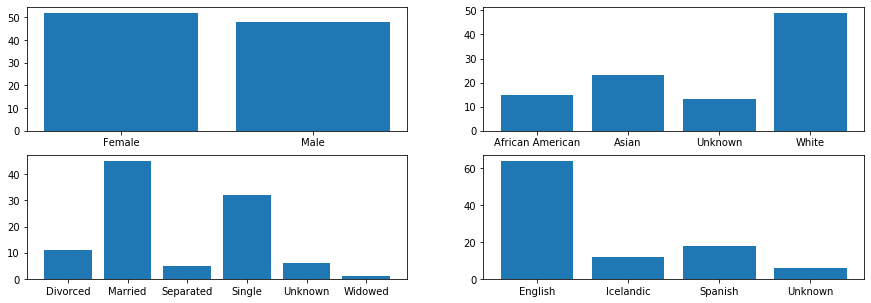

In [13]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,5))
patient_grouped_df = patient_df.groupby('PatientGender')['PatientID'].nunique().reset_index()
ax1.bar(patient_grouped_df["PatientGender"],patient_grouped_df["PatientID"])
patient_grouped_df = patient_df.groupby('PatientRace')['PatientID'].nunique().reset_index()
ax2.bar(patient_grouped_df["PatientRace"],patient_grouped_df["PatientID"])
patient_grouped_df = patient_df.groupby('PatientMaritalStatus')['PatientID'].nunique().reset_index()
ax3.bar(patient_grouped_df["PatientMaritalStatus"],patient_grouped_df["PatientID"])
patient_grouped_df = patient_df.groupby('PatientLanguage')['PatientID'].nunique().reset_index()
ax4.bar(patient_grouped_df["PatientLanguage"],patient_grouped_df["PatientID"])

The graphs show distribution of categories across the patients. The goal is to understand why some groups are favoured compared to others

Creating age groups - Grouping creates categories of ages for better clustering

<BarContainer object of 9 artists>

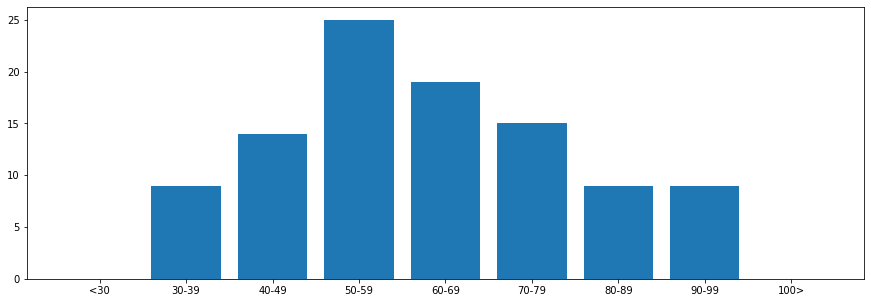

In [14]:
bins = [0, 30, 40, 50, 60, 70, 80, 90, 100, 120]
labels = ['<30', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100>']
patient_df['AgeRange'] = pd.cut(patient_df.Age, bins, labels = labels,include_lowest = True)

plt.figure(figsize=(15,5))
patient_grouped_df = patient_df.groupby('AgeRange')['PatientID'].nunique().reset_index()
plt.bar(patient_grouped_df["AgeRange"],patient_grouped_df["PatientID"])

### Admission Data Distribution

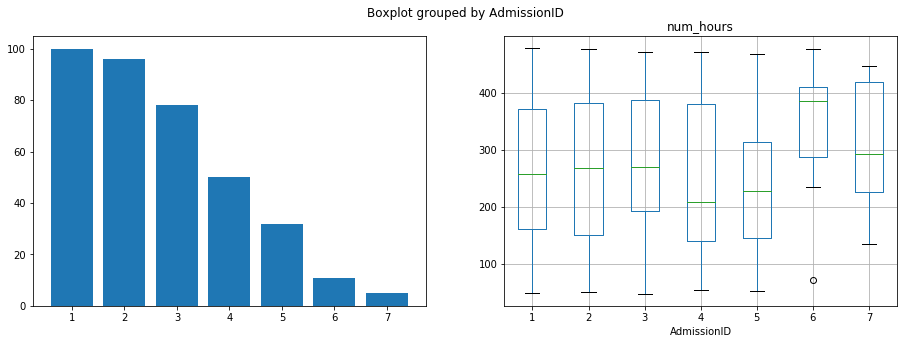

In [15]:
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,5))
admission_grouped_df = admissions_df.groupby('AdmissionID')['PatientID'].nunique().reset_index()
ax1.bar(admission_grouped_df["AdmissionID"],admission_grouped_df["PatientID"])
admissions_df.boxplot(column=['num_hours'], by='AdmissionID', ax=ax2)

The bar chart shows the earlier visits to have more patients. The boxplot shows the visit number which takes up most of the time.

### Diagnosis Data Distribution

In [16]:
diagnoses_grouped_df = diagnoses_df.groupby('PrimaryDiagnosisCode')['PatientID'].nunique().reset_index()
diagnoses_grouped_df.head()

,PrimaryDiagnosisCode,PatientID
0,A42.0,1
1,A48.2,1
2,A52.0,1
3,A83.6,1
4,A98.3,1


Dividing the PrimaryDiagnosisCode into multiple columns to be able to create better clusters

In [17]:
diagnoses_df["OverallDiagnosisCode"] = diagnoses_df["PrimaryDiagnosisCode"].str[0]

diagnoses_df["DiagnosisCode1"] = diagnoses_df["PrimaryDiagnosisCode"].str.split(".")
diagnoses_df["DiagnosisCode1"] = diagnoses_df["DiagnosisCode1"].apply(lambda x: x[0])

diagnoses_df["DiagnosisCode2"] = diagnoses_df["PrimaryDiagnosisCode"].str.split(".")
diagnoses_df["DiagnosisCode2"] = diagnoses_df["DiagnosisCode2"].apply(lambda x: "" if len(x) < 2 else x[1])

diagnoses_df.head()

,PatientID,AdmissionID,PrimaryDiagnosisCode,PrimaryDiagnosisDescription,OverallDiagnosisCode,DiagnosisCode1,DiagnosisCode2
0,80AC01B2-BD55-4BE0-A59A-4024104CF4E9,2,M01.X,Direct infection of joint in infectious and pa...,M,M01,X
1,80AC01B2-BD55-4BE0-A59A-4024104CF4E9,3,D65,Disseminated intravascular coagulation [defibr...,D,D65,
2,80AC01B2-BD55-4BE0-A59A-4024104CF4E9,4,C92.1,"Chronic myeloid leukemia, BCR/ABL-positive",C,C92,1
3,80AC01B2-BD55-4BE0-A59A-4024104CF4E9,5,M05.51,Rheumatoid polyneuropathy with rheumatoid arth...,M,M05,51
4,6A57AC0C-57F3-4C19-98A1-51135EFBC4FF,1,C91.00,Acute lymphoblastic leukemia not having achiev...,C,C91,00


Understanding the common OverallDiagnosisCode among different patients

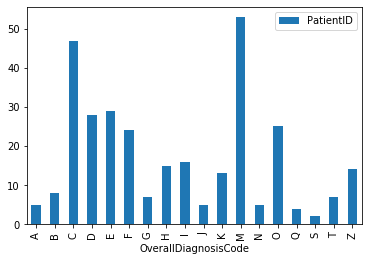

In [18]:
diagnoses_grouped_df = diagnoses_df.groupby('OverallDiagnosisCode')['PatientID'].nunique().reset_index()
diagnoses_grouped_df.plot.bar(x="OverallDiagnosisCode" , y="PatientID")

In [19]:
diagnoses_df[diagnoses_df["OverallDiagnosisCode"] == "Z"].head(15)

,PatientID,AdmissionID,PrimaryDiagnosisCode,PrimaryDiagnosisDescription,OverallDiagnosisCode,DiagnosisCode1,DiagnosisCode2
38,9C75DF1F-9DA6-4C98-8F5B-E10BDC805ED0,1,Z13.810,Encounter for screening for upper gastrointest...,Z,Z13,810
40,A19A0B00-4C9A-4206-B1FE-17E6DA3CEB0B,1,Z13.83,Encounter for screening for respiratory disord...,Z,Z13,83
54,FA157FA5-F488-4884-BF87-E144630D595C,5,Z13.85,Encounter for screening for nervous system dis...,Z,Z13,85
64,DA6CECFF-DE13-4C4C-919F-64E1A2B76C9D,4,Z22.31,Carrier of bacterial disease due to meningococci,Z,Z22,31
88,25B786AF-0F99-478C-9CFA-0EA607E45834,6,Z22.31,Carrier of bacterial disease due to meningococci,Z,Z22,31
135,69B5D2A0-12FD-46EF-A5FF-B29C4BAFBE49,1,Z91.15,Patient's noncompliance with renal dialysis,Z,Z91,15
141,8D389A8C-A6D8-4447-9DDE-1A28AB4EC667,2,Z13.22,Encounter for screening for metabolic disorder,Z,Z13,22
157,49DADA25-F2C2-42BB-8210-D78E6C7B0D48,1,Z12,Encounter for screening for malignant neoplasms,Z,Z12,
218,9E18822E-7D13-45C7-B50E-F95CFF92BC3E,1,Z13.0,Encounter for screening for diseases of the bl...,Z,Z13,0
229,98F593D2-8894-49BB-93B9-5A0E2CF85E2E,1,Z12.2,Encounter for screening for malignant neoplasm...,Z,Z12,2


The splitting of PrimaryDiagnosis to different columns makes sense when looking at the data above.
For example the rows 2, 3 & 7 show how the descriptions vary with the specific detail when you compare the codes

## Data Preparation

Combining the datasets into one dataframe

In [20]:
admitted_diagnoses_df = pd.merge(admissions_df,diagnoses_df,on=['PatientID','AdmissionID'], how='left')
admitted_diagnoses_df.drop(columns=["AdmissionStartDate", "AdmissionEndDate", "PrimaryDiagnosisCode", "PrimaryDiagnosisDescription"], inplace=True)
admit_patient_diag_df = pd.merge(admitted_diagnoses_df,patient_df,on=['PatientID'], how='left')
admit_patient_diag_df.drop(columns=["PatientDateOfBirth", "PatientPopulationPercentageBelowPoverty", "Age"], inplace=True)
admit_patient_lab_diag_df = pd.merge(admit_patient_diag_df, labs_df, on=['PatientID', 'AdmissionID'], how='left')
admit_patient_lab_diag_df.drop(columns=["PatientID", "LabUnits", "LabDateTime"], inplace=True)
admit_patient_lab_diag_df.head()

,AdmissionID,num_hours,OverallDiagnosisCode,DiagnosisCode1,DiagnosisCode2,PatientGender,PatientRace,PatientMaritalStatus,PatientLanguage,AgeRange,LabName,LabValue
0,7,226.0,F,F06,3,Female,Asian,Single,English,60-69,CBC: WHITE BLOOD CELL COUNT,3.1
1,7,226.0,F,F06,3,Female,Asian,Single,English,60-69,CBC: MCH,33.0
2,7,226.0,F,F06,3,Female,Asian,Single,English,60-69,CBC: LYMPHOCYTES,3.3
3,7,226.0,F,F06,3,Female,Asian,Single,English,60-69,METABOLIC: TOTAL PROTEIN,5.3
4,7,226.0,F,F06,3,Female,Asian,Single,English,60-69,URINALYSIS: RED BLOOD CELLS,2.9


In [21]:
admit_patient_lab_diag_df.dtypes

AdmissionID                int64
num_hours                float64
OverallDiagnosisCode      object
DiagnosisCode1            object
DiagnosisCode2            object
PatientGender             object
PatientRace               object
PatientMaritalStatus      object
PatientLanguage           object
AgeRange                category
LabName                   object
LabValue                 float64
dtype: object

Converting the string values into categories and later into integers with integer encoding 

In [22]:
admit_patient_lab_diag_df["OverallDiagnosisCode"] = admit_patient_lab_diag_df["OverallDiagnosisCode"].astype('category')
admit_patient_lab_diag_df["DiagnosisCode1"] = admit_patient_lab_diag_df["DiagnosisCode1"].astype('category')
admit_patient_lab_diag_df["DiagnosisCode2"] = admit_patient_lab_diag_df["DiagnosisCode2"].astype('category')
admit_patient_lab_diag_df["PatientGender"] = admit_patient_lab_diag_df["PatientGender"].astype('category')
admit_patient_lab_diag_df["PatientRace"] = admit_patient_lab_diag_df["PatientRace"].astype('category')
admit_patient_lab_diag_df["PatientMaritalStatus"] = admit_patient_lab_diag_df["PatientMaritalStatus"].astype('category')
admit_patient_lab_diag_df["PatientLanguage"] = admit_patient_lab_diag_df["PatientLanguage"].astype('category')
admit_patient_lab_diag_df["LabName"] = admit_patient_lab_diag_df["LabName"].astype('category')

In [23]:
admit_patient_lab_diag_df["OverallDiagnosisCode_cat"] = admit_patient_lab_diag_df["OverallDiagnosisCode"].cat.codes
admit_patient_lab_diag_df["DiagnosisCode1_cat"] = admit_patient_lab_diag_df["DiagnosisCode1"].cat.codes
admit_patient_lab_diag_df["DiagnosisCode2_cat"] = admit_patient_lab_diag_df["DiagnosisCode2"].cat.codes
admit_patient_lab_diag_df["PatientGender_cat"] = admit_patient_lab_diag_df["PatientGender"].cat.codes
admit_patient_lab_diag_df["PatientRace_cat"] = admit_patient_lab_diag_df["PatientRace"].cat.codes
admit_patient_lab_diag_df["PatientMaritalStatus_cat"] = admit_patient_lab_diag_df["PatientMaritalStatus"].cat.codes
admit_patient_lab_diag_df["PatientLanguage_cat"] = admit_patient_lab_diag_df["PatientLanguage"].cat.codes
admit_patient_lab_diag_df["AgeRange_cat"] = admit_patient_lab_diag_df["AgeRange"].cat.codes
admit_patient_lab_diag_df["LabName_cat"] = admit_patient_lab_diag_df["LabName"].cat.codes

## Modeling

### Data Preprocessing

In [24]:
input_df = admit_patient_lab_diag_df[['AdmissionID', 'num_hours', 'OverallDiagnosisCode_cat', 'DiagnosisCode1_cat',
                                      'DiagnosisCode2_cat', 'PatientGender_cat', 'PatientRace_cat',
                                      'PatientMaritalStatus_cat', 'PatientLanguage_cat', 'AgeRange_cat',
                                      'LabName_cat', 'LabValue']]

In [25]:
input_df.shape

(111483, 12)

In [26]:
input_df.columns

Index(['AdmissionID', 'num_hours', 'OverallDiagnosisCode_cat',
       'DiagnosisCode1_cat', 'DiagnosisCode2_cat', 'PatientGender_cat',
       'PatientRace_cat', 'PatientMaritalStatus_cat', 'PatientLanguage_cat',
       'AgeRange_cat', 'LabName_cat', 'LabValue'],
      dtype='object')

In [27]:
# Converting dataframe to numpy array required for the model.
input_numpy_arr_data = input_df.values

### Initializing and training the model

In [28]:
# Using 6X6 neurons to learn from the data and create clusters
som = MiniSom(6, 6, input_len = input_df.shape[1], sigma=0.5, learning_rate=0.5)
som.train_random(input_numpy_arr_data, 500)

### Clustering a random data record

In [29]:
# Finding which neuron is the winner(closest) to the test data
som.winner(input_numpy_arr_data[0])

(2, 0)

## Next Steps

1) Identifying how good the SOM(Self Organizing Maps) is performing in terms of creating the clusters.

2) Use other unsupervised clustering models to create the clusters

3) Comparing the models and identify the best one.